In [407]:
# Install necessary libraries
!pip install pandas matplotlib seaborn statsmodels arch corrplot

ERROR: Could not find a version that satisfies the requirement corrplot (from versions: none)
ERROR: No matching distribution found for corrplot


In [408]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [515]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import seaborn as sns
import pandas as pd
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.api as SMS
from sklearn.metrics import mean_squared_error



In [410]:
# Import Bitcoin Price Data
bitcoin_data = pd.read_csv('BTC_USD_2018_2024.csv')
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'], format='%d/%m/%Y')
bitcoin_data.sort_values('Date', inplace=True)

In [411]:
# Import Macroeconomic Data
macro_data = pd.read_csv('Macroeconomic.csv')
macro_data['Date'] = pd.to_datetime(macro_data['Date'], format='%d/%m/%Y')
macro_data.sort_values('Date', inplace=True)

In [412]:
# Import Hash Rate Data
hash_rate_data = pd.read_csv('Bitcoin_Weekly_HashRate_2019_2024.csv')
hash_rate_data['Date'] = pd.to_datetime(hash_rate_data['Date'], format='%d/%m/%Y')
hash_rate_data.sort_values('Date', inplace=True)

In [649]:
# Merge Bitcoin data with macroeconomic data and hash rate data on Date
merged_data = pd.merge(bitcoin_data, macro_data, on='Date', how='left')
merged_data = pd.merge(merged_data, hash_rate_data, on='Date', how='left')
# Ensure 'Date' column is datetime if it's not already
merged_data['Date'] = pd.to_datetime(merged_data['Date']) 

In [651]:
# Preview the datasets
display(merged_data.head())


,Date,Open,High,Low,Close,Volume,Adjusted,S&P 500,Interest Rate,Hash Rate
0,2018-01-01,14112.20020,14112.20020,13154.7002,13657.20020,1.029120e+10,13657.20020,2673.61,1.42,16127548.73
1,2018-01-08,16476.19922,16537.90039,14208.2002,15170.09961,1.841390e+10,15170.09961,2743.15,1.37,17087521.86
2,2018-01-15,13767.29980,14445.50000,13641.7002,13819.79980,1.275080e+10,13819.79980,2786.24,1.42,19712949.41
3,2018-01-22,11633.09961,11966.40039,10240.2002,10931.40039,1.053740e+10,10931.40039,2810.30,1.42,20056949.54
4,2018-01-29,11755.50000,11875.59961,11179.2002,11296.40039,7.107360e+09,11296.40039,2872.87,1.42,20445148.56


In [653]:
# Log Transform Bitcoin Close price and Hash Rate
merged_data['log_btc'] = np.log(merged_data['Close'])
merged_data['log_hashrate'] = np.log(merged_data['Hash Rate'])

In [416]:
# **2. Descriptive Statistics**

In [655]:
# Calculate descriptive statistics for Bitcoin price
bitcoin_price_stats = merged_data.describe()
display(bitcoin_price_stats)


,Date,Open,High,Low,Close,Volume,Adjusted,S&P 500,Interest Rate,Hash Rate,log_btc,log_hashrate
count,366,366.000000,366.000000,366.000000,366.000000,3.660000e+02,366.000000,366.000000,366.000000,3.660000e+02,366.000000,366.000000
mean,2021-07-01 12:00:00.000000256,28078.492926,28833.426062,27324.841155,28165.047555,2.877240e+10,28165.047555,3849.527678,2.320683,2.307649e+08,9.891440,18.846560
min,2018-01-01 00:00:00,3253.123047,3476.223877,3253.123047,3459.154053,3.665100e+09,3459.154053,2304.920000,0.040000,1.612755e+07,8.148779,16.596039
25%,2019-10-01 18:00:00,8919.039795,9045.422851,8736.953369,8927.647705,1.516545e+10,8927.647705,2942.730000,0.092500,8.932770e+07,9.096908,18.307821
50%,2021-07-01 12:00:00,21971.703125,22608.663085,21531.992185,22400.103515,2.647054e+10,22400.103515,3901.210000,1.915000,1.487379e+08,10.016820,18.817696
75%,2023-04-01 06:00:00,42260.435550,43693.905273,41699.552735,42649.885743,3.773716e+10,42649.885743,4448.157500,4.580000,3.275728e+08,10.660780,19.607213
max,2024-12-30 00:00:00,104293.578100,107780.578100,103322.984400,106029.718800,1.233210e+11,106029.718800,6090.270000,5.330000,8.677102e+08,11.571475,20.581368
std,NaN,22193.090501,22819.979460,21599.082864,22286.975370,1.975098e+10,22286.975370,921.104286,1.981583,2.038450e+08,0.888787,0.956184


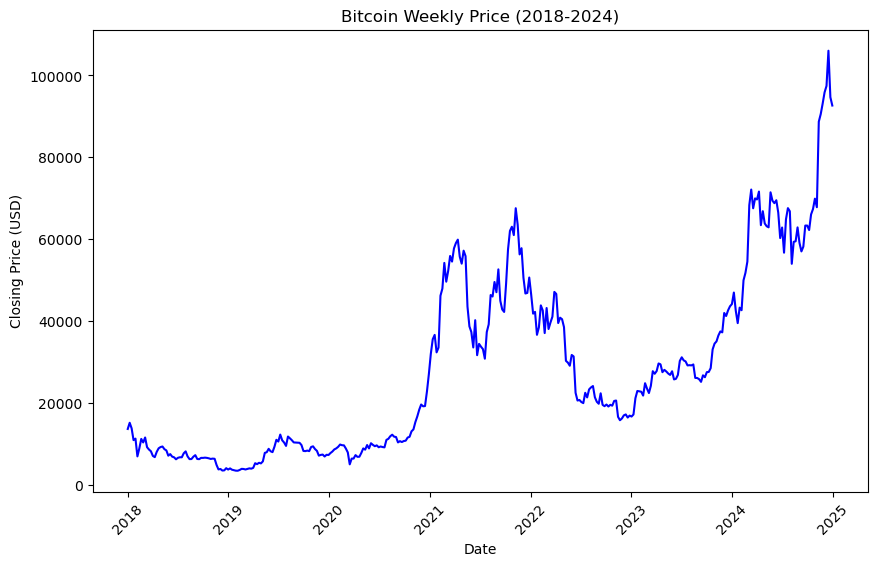

In [657]:
# Plot Bitcoin Price Time Series
plt.figure(figsize=(10,6))
plt.plot(merged_data['Date'], merged_data['Close'], color='blue')
plt.title('Bitcoin Weekly Price (2018-2024)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.xticks(rotation=45)
plt.show()


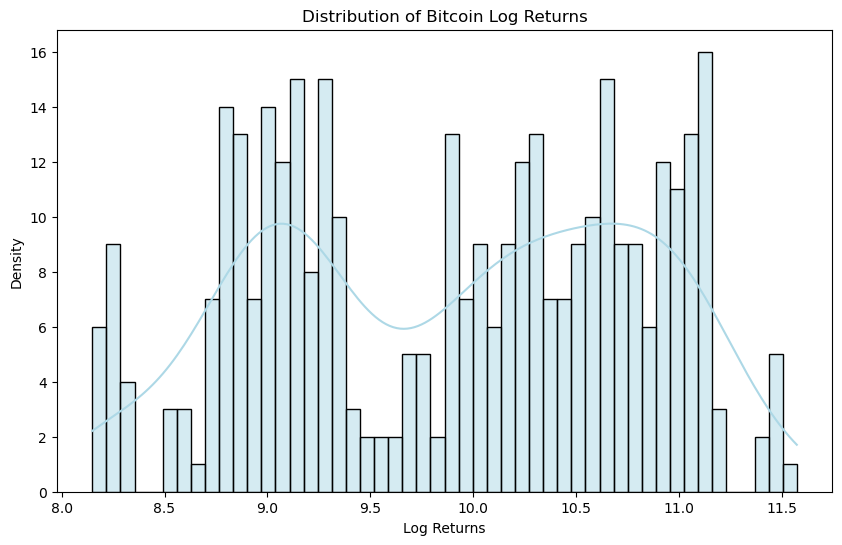

In [609]:
# Plot log the distribution of returns
plt.figure(figsize=(10,6))
sns.histplot(merged_data['log_btc'], bins=50, kde=True, color='lightblue', edgecolor='black')
plt.title('Distribution of Bitcoin Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.show()



In [659]:
# **Correlation Analysis (Bitcoin Price vs Macroeconomic Variables)**
correlation_matrix = merged_data[['Close', 'Interest Rate', 'S&P 500']].corr()
print(correlation_matrix)

                  Close  Interest Rate   S&P 500
Close          1.000000       0.317904  0.919427
Interest Rate  0.317904       1.000000  0.479929
S&P 500        0.919427       0.479929  1.000000


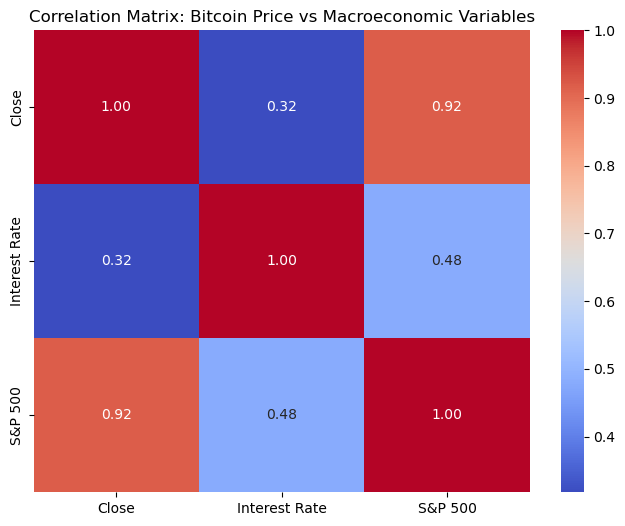

In [661]:
# Visualize the correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix: Bitcoin Price vs Macroeconomic Variables')
plt.show()

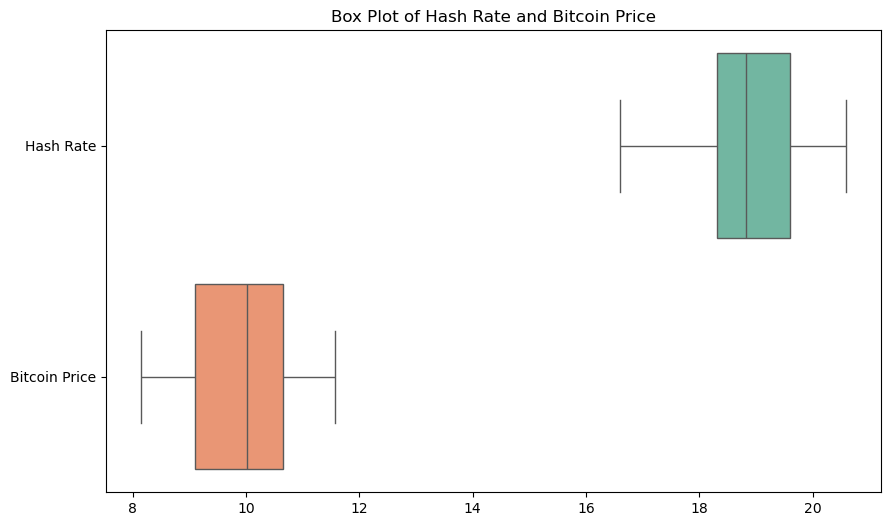

In [663]:
# **3. Box Plot for Bitcoin Price vs. Hash Rate**
plt.figure(figsize=(10,6))
sns.boxplot(data=[merged_data['log_hashrate'], merged_data['log_btc']], 
            orient='h', palette='Set2')
plt.yticks([0, 1], ['Hash Rate', 'Bitcoin Price'])
plt.title('Box Plot of Hash Rate and Bitcoin Price')
plt.show()

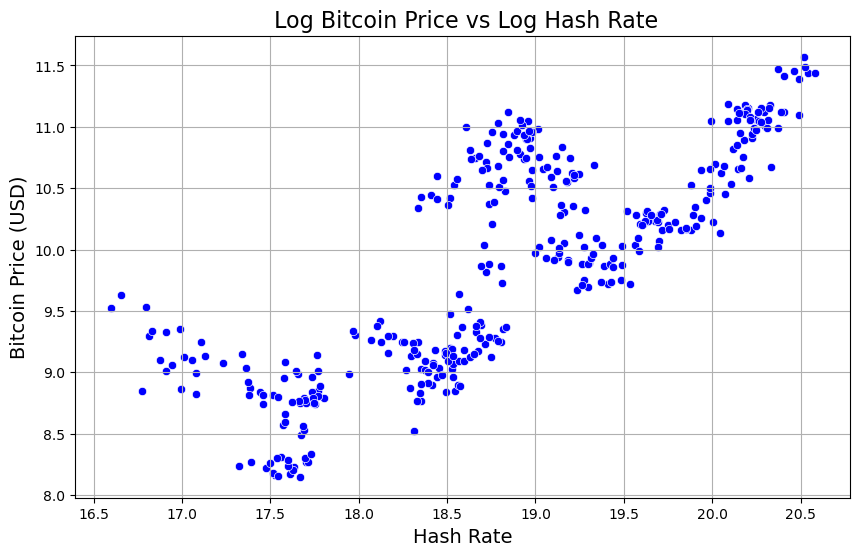

In [665]:
# Scatter plot of Bitcoin Price vs Hash Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_data['log_hashrate'], y=merged_data['log_btc'], color='blue')
plt.title(' Log Bitcoin Price vs Log Hash Rate', fontsize=16)
plt.xlabel('Hash Rate', fontsize=14)
plt.ylabel('Bitcoin Price (USD)', fontsize=14)
plt.grid(True)
plt.show()

ADF test p-value for Price Series: 0.9496694408975996
ADF test p-value for Log Returns Series: 0.9108945210366923


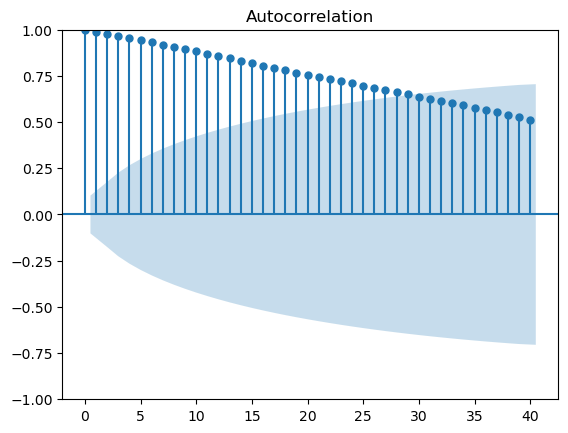

In [667]:
# Conduct Augmented Dickey-Fuller test on original and return series
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1]

adf_test_price = adf_test(merged_data['Close'])
adf_test_returns = adf_test(merged_data['log_btc'])
print(f'ADF test p-value for Price Series: {adf_test_price}')
print(f'ADF test p-value for Log Returns Series: {adf_test_returns}')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(merged_data['log_btc'], lags=40)
plt.show()


In [669]:
model = ARIMA(merged_data['log_btc'], order=(1, 0, 1))  # ARIMA(p,d,q) with p=1, d=0, q=1
model_fit = model.fit()

# Display the summary of the model fit
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                log_btc   No. Observations:                  366
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 324.395
Date:                Sun, 30 Mar 2025   AIC                           -640.791
Time:                        11:00:38   BIC                           -625.180
Sample:                             0   HQIC                          -634.587
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1872      0.817     12.465      0.000       8.585      11.789
ar.L1          0.9946      0.006    177.028      0.000       0.984       1.006
ma.L1       1.827e-05      0.043      0.000      1.0

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted', 'S&P 500',
       'Interest Rate', 'Hash Rate', 'log_btc', 'log_hashrate'],
      dtype='object')
Open             0
High             0
Low              0
Close            0
Volume           0
Adjusted         0
S&P 500          0
Interest Rate    0
Hash Rate        0
log_btc          0
log_hashrate     0
dtype: int64


C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


74 74


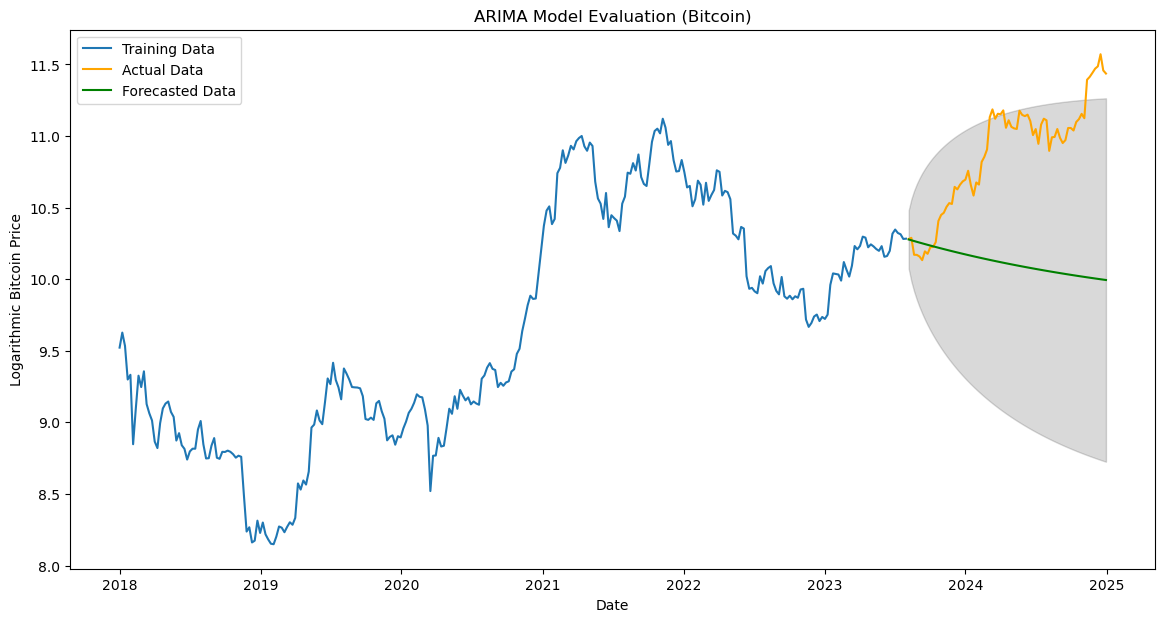

RMSE: 0.885408043770847


In [621]:
# Check the column names to find the correct one for the date
print(merged_data.columns)

# Assuming 'Date' is the correct column name for the date
merged_data['Date'] = pd.to_datetime(merged_data['Date'])  # Adjust to correct column name
merged_data.set_index('Date', inplace=True)
# Split the data into train and test (80-20 split)
train_size = int(len(merged_data) * 0.8)
train, test = merged_data[0:train_size], merged_data[train_size:len(merged_data)]

# Check if any missing data exists
print(merged_data.isnull().sum())  # This will check the entire dataframe for missing values

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['log_btc'], order=(1, 0, 1))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Ensure the forecast index matches the test index
test_forecast_series.index = test.index
# Check if the lengths of test data and forecasted data are the same
print(len(test), len(test_forecast_series))  # Both should be equal

# Calculate the mean squared error and RMSE
mse = mean_squared_error(test['log_btc'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['log_btc'], label='Training Data')
plt.plot(test['log_btc'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation (Bitcoin)')
plt.xlabel('Date')
plt.ylabel('Logarithmic Bitcoin Price')
plt.legend()
plt.show()

# Print RMSE
print('RMSE:', rmse)

In [671]:
# Fit GARCH model
garch_model = arch_model(merged_data['log_btc'].dropna(), vol='Garch', p=1, q=1)
garch_result = garch_model.fit()
print(garch_result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4013872740650.8066
Iteration:      2,   Func. Count:     14,   Neg. LLF: 289411800.13833874
Iteration:      3,   Func. Count:     21,   Neg. LLF: 398.7615927854818
Iteration:      4,   Func. Count:     27,   Neg. LLF: 363.0885214813627
Iteration:      5,   Func. Count:     33,   Neg. LLF: 354.36899890012205
Iteration:      6,   Func. Count:     39,   Neg. LLF: 366.9643290932594
Iteration:      7,   Func. Count:     45,   Neg. LLF: 333.9082112563432
Iteration:      8,   Func. Count:     50,   Neg. LLF: 381.1972921610443
Iteration:      9,   Func. Count:     56,   Neg. LLF: 440.5883497909734
Iteration:     10,   Func. Count:     62,   Neg. LLF: 398.2706611476049
Iteration:     11,   Func. Count:     68,   Neg. LLF: 368.1224043132102
Iteration:     12,   Func. Count:     74,   Neg. LLF: 335.3464024410288
Iteration:     13,   Func. Count:     80,   Neg. LLF: 330.4610210534761
Iteration:     14,   Func. Count:     85,   Neg. LLF: 330.325

In [673]:
# Extracting the conditional volatility (standard deviation)
garch_cond_volatility = garch_result.conditional_volatility# Extracting the residuals (from fitted values)
residuals = garch_result.resid


In [675]:
# Standardized residuals: residuals divided by the conditional volatility
garch_standardized_residuals = garch_result.resid / garch_cond_volatility



In [677]:
print(merged_data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted', 'S&P 500',
       'Interest Rate', 'Hash Rate', 'log_btc', 'log_hashrate'],
      dtype='object')


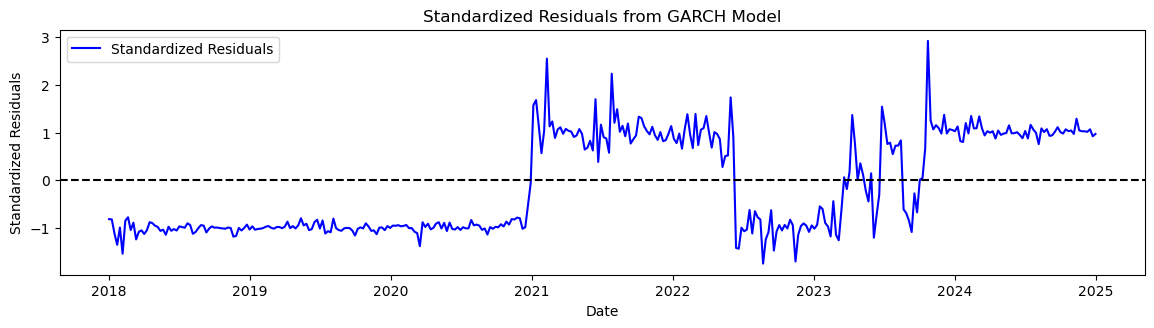

In [679]:
# Plotting the standardized residuals and conditional volatility
plt.figure(figsize=(14, 7))

# Plot 1: Standardized Residuals
plt.subplot(2, 1, 1)
plt.plot(merged_data['Date'], garch_standardized_residuals, label="Standardized Residuals", color='blue')
plt.title('Standardized Residuals from GARCH Model')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.legend()

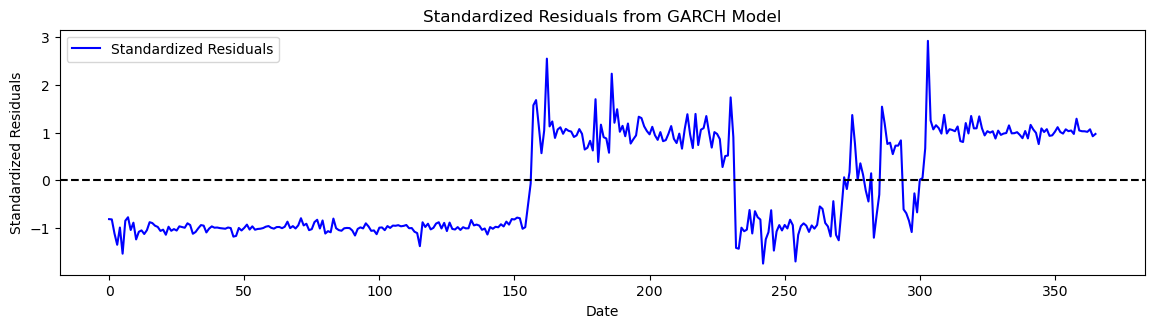

In [703]:
# Plotting the standardized residuals and conditional volatility
plt.figure(figsize=(14, 7))

# Plot 1: Standardized Residuals
plt.subplot(2, 1, 1)
plt.plot(merged_data.index, garch_standardized_residuals, label="Standardized Residuals", color='blue')
plt.title('Standardized Residuals from GARCH Model')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.legend()

In [681]:
# Annualize the volatility (assuming daily returns, multiply by sqrt(252) for annualization)
annualized_garch_volatility = garch_cond_volatility * np.sqrt(252)

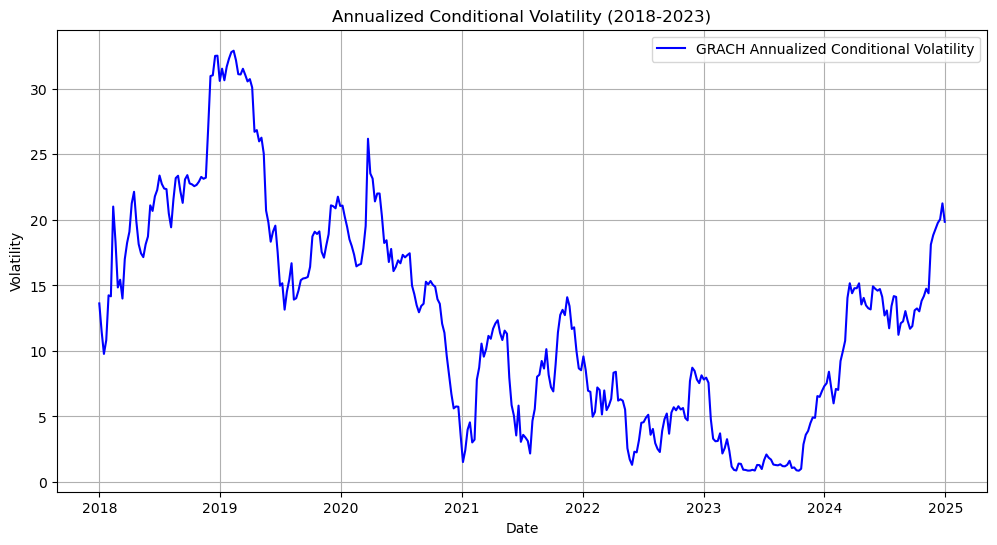

In [683]:
# Plot the annualized GARCH volatility
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], annualized_volatility, label='GRACH Annualized Conditional Volatility', color='blue')
plt.title('Annualized Conditional Volatility (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [623]:
# Fit an EGARCH model
egarch_model = arch_model(merged_data['log_btc'].dropna(), vol='EGarch', p=1, q=1)
egarch_fit = egarch_model.fit()
print(egarch_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3262879376386.4043
Iteration:      2,   Func. Count:     14,   Neg. LLF: 636327730100.5442
Iteration:      3,   Func. Count:     22,   Neg. LLF: 407065550.200894
Iteration:      4,   Func. Count:     29,   Neg. LLF: 4522.708479461535
Iteration:      5,   Func. Count:     35,   Neg. LLF: 338.7552478057369
Iteration:      6,   Func. Count:     41,   Neg. LLF: 777.3403162812058
Iteration:      7,   Func. Count:     49,   Neg. LLF: 370.29417659252556
Iteration:      8,   Func. Count:     55,   Neg. LLF: 338.6754708100043
Iteration:      9,   Func. Count:     61,   Neg. LLF: 332.73960663361225
Iteration:     10,   Func. Count:     66,   Neg. LLF: 332.4317035252099
Iteration:     11,   Func. Count:     71,   Neg. LLF: 332.17625262983347
Iteration:     12,   Func. Count:     76,   Neg. LLF: 331.634941632175
Iteration:     13,   Func. Count:     81,   Neg. LLF: 331.47507012901485
Iteration:     14,   Func. Count:     86,   Neg. LLF: 331.439

In [685]:
# Extracting the conditional volatility (standard deviation)
egarch_cond_volatility = egarch_fit.conditional_volatility
# Extracting the residuals (from fitted values)
residuals = egarch_fit.resid

In [687]:
# Standardized residuals for EGARCH
egarch_standardized_residuals = egarch_fit.resid / egarch_cond_volatility


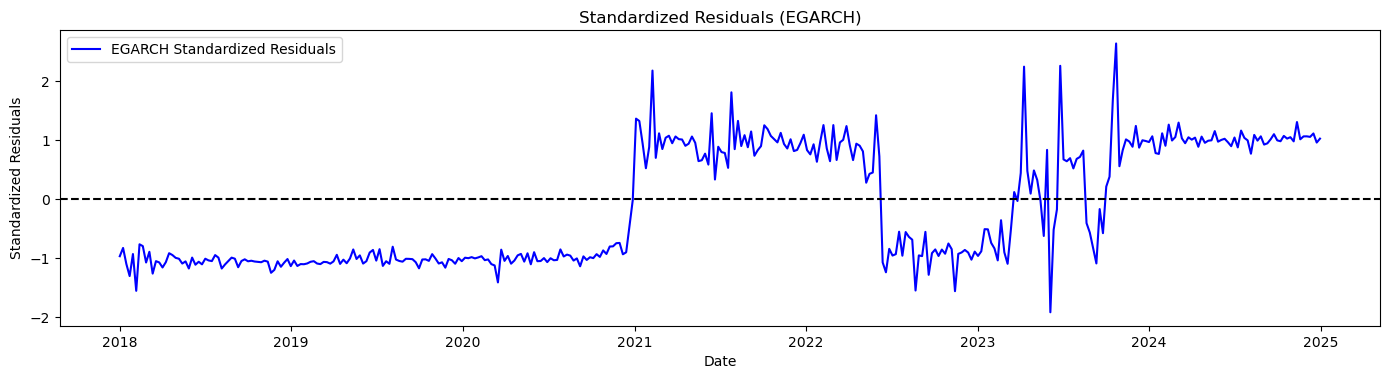

In [689]:
# Plotting the standardized residuals and conditional volatility
plt.figure(figsize=(14, 7))

# Plot 1: Standardized Residuals
plt.subplot(2, 1, 1)
plt.plot(merged_data['Date'], egarch_standardized_residuals, label="EGARCH Standardized Residuals", color='blue')
plt.title('Standardized Residuals (EGARCH)')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

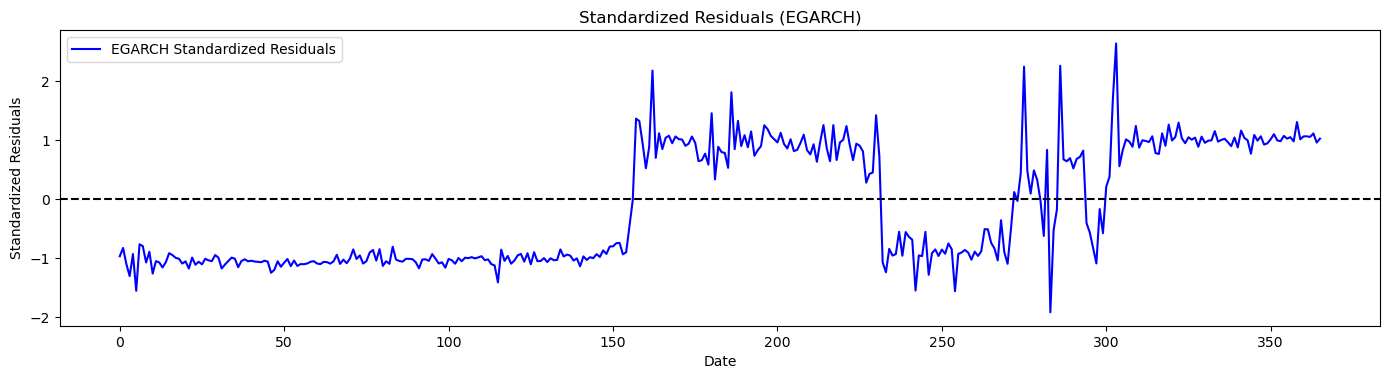

In [705]:

# Plotting the standardized residuals and conditional volatility
plt.figure(figsize=(14, 7))

# Plot 1: Standardized Residuals
plt.subplot(2, 1, 1)
plt.plot(merged_data.index, egarch_standardized_residuals, label="EGARCH Standardized Residuals", color='blue')
plt.title('Standardized Residuals (EGARCH)')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

In [633]:
# Annualize the volatility (assuming daily returns, multiply by sqrt(252) for annualization)
annualized_egarch_volatility = egarch_cond_volatility * np.sqrt(252)

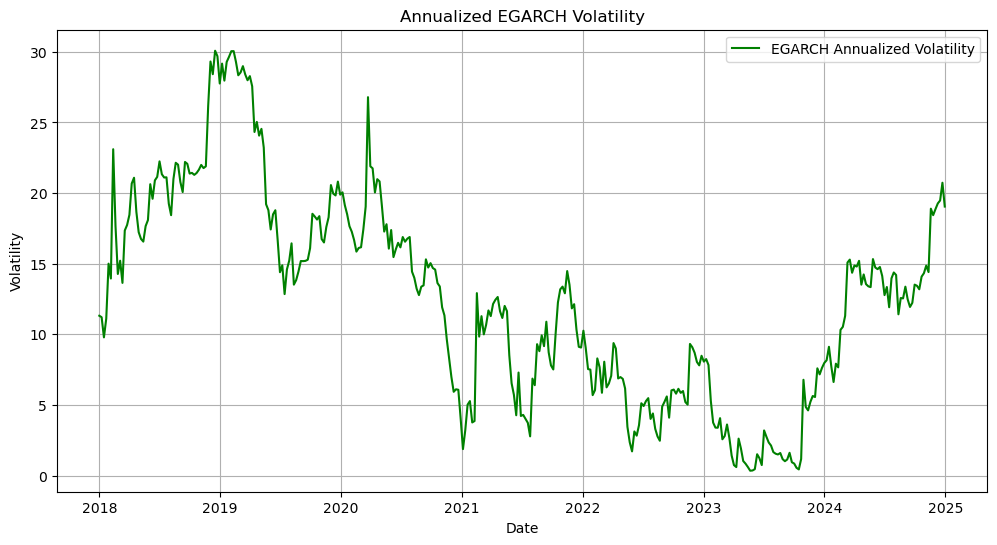

In [691]:
# Plot the annualized EGARCH volatility
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data['Date'], annualized_egarch_volatility, label='EGARCH Annualized Volatility', color='green')
plt.title('Annualized EGARCH Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


In [693]:
# **5. Regression Analysis to Identify Key Influencing Factors**
# Prepare data for regression model
X = merged_data[['Hash Rate', 'S&P 500', 'Interest Rate']]
y = merged_data['Close']

# Add constant to the model
X = sm.add_constant(X) 

In [695]:
# Fit the regression model
regression_model = LinearRegression()
regression_model.fit(X, y)

LinearRegression()

In [697]:
# Print the regression coefficients
print(f"Intercept: {regression_model.intercept_}")
print(f"Coefficients: {regression_model.coef_}")


Intercept: -47175.35244526764
Coefficients: [ 0.00000000e+00  3.00546755e-05  1.96633199e+01 -3.14116983e+03]


In [699]:
# OLS Regression Analysis to Identify Key Influencing Factors
ols_model = sm.OLS(y, X).fit()
model_summary = ols_model.summary()
# Display the summary
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     820.5
Date:                Sun, 30 Mar 2025   Prob (F-statistic):          4.81e-161
Time:                        11:01:48   Log-Likelihood:                -3807.2
No. Observations:                 366   AIC:                             7622.
Df Residuals:                     362   BIC:                             7638.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.718e+04   3571.348    -13.209

In [701]:
# **ARIMA Model**: Compute AIC and BIC
arima_aic = arima_result.aic
arima_bic = arima_result.bic

print(f"ARIMA Model AIC: {arima_aic}")
print(f"ARIMA Model BIC: {arima_bic}")

# **GARCH Model**: Compute AIC and BIC
garch_aic = garch_result.aic
garch_bic = garch_result.bic

print(f"GARCH Model AIC: {garch_aic}")
print(f"GARCH Model BIC: {garch_bic}")

# **EGARCH Model**: Compute AIC and BIC
egarch_aic = egarch_fit.aic
egarch_bic = egarch_fit.bic

print(f"EGARCH Model AIC: {egarch_aic}")
print(f"EGARCH Model BIC: {egarch_bic}")

#  OLS Model**: Compute AIC and BIC
ols_aic = ols_model.aic
ols_bic = ols_model.bic

print(f"OLS Model AIC: {ols_aic}")
print(f"OLS Model BIC: {ols_bic}")

ARIMA Model AIC: -642.8338556517617
ARIMA Model BIC: -619.4344715302668
GARCH Model AIC: 668.574032142505
GARCH Model BIC: 684.1845654761104
EGARCH Model AIC: 670.8005758972126
EGARCH Model BIC: 686.411109230818
OLS Model AIC: 7622.454527516007
OLS Model BIC: 7638.065060849613
